# Anomaly detection for clickstream data

## 0. Exploring data and date preparation

데이터 소스 : https://github.com/hortonworks/fieldeng-modern-clickstream

In [1]:
!gzip -d *.gz

gzip: *.gz: No such file or directory


In [2]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

#### products dataset
- 16개의 타겟 페이지 (제품처럼 생각할 수 있을 듯)

In [3]:
products = pd.read_csv('products.tsv', header=None)
columns = pd.DataFrame(products[0].str.strip().str.split('\t').tolist()[0])
products = pd.DataFrame(products[0].str.strip().str.split('\t').tolist()[1:])
products.columns = columns
products

,"(url,)","(category,)","(id,)"
0,/,home page,1000
1,/video/1001,video review,1001
2,/video/1002,video review,1002
3,/video/1003,video review,1003
4,/reco/2001,celebirity recommendation,2001
5,/reco/2002,celebirity recommendation,2002
6,/review/3001,customer review,3001
7,/review/3002,customer review,3002
8,/review/3003,customer review,3003
9,/review/3004,customer review,3004


#### users dataset
- SWID는 사용자 세션 아이디임

In [4]:
users = pd.read_csv('users.tsv', delimiter='\t')
users

,SWID,BIRTH_DT,GENDER_CD
0,0001BDD9-EABF-4D0D-81BD-D9EABFCD0D7D,8-Apr-84,F
1,00071AA7-86D2-4EB9-871A-A786D27EB9BA,7-Feb-88,F
2,00071B7D-31AF-4D85-871B-7D31AFFD852E,22-Oct-64,F
3,0007967E-F188-4598-9C7C-E64390482CFB,1-Jun-66,M
4,000B90B2-92DC-4A7A-8B90-B292DC9A7A71,13-Jun-84,M
...,...,...,...
38450,FFF69D73-CE85-4BD6-B10F-9F9F25CD7A74,19-Apr-87,M
38451,FFF9E6CB-D3A2-455F-B5CF-6B8EC4E80ABE,21-Mar-53,U
38452,FFFB1C5E-37B6-453A-83FB-86C580D18AE8,24-Jan-90,M
38453,NaN,NaN,NaN


#### clickstreams 
- 이 데이터가 메인임

In [5]:
cs = pd.read_csv('clickstream-feed-generated.tsv', header=None, delimiter='|')
cs.columns = pd.read_csv('clickstream-data-schema.txt', delimiter='|').columns
cs['timestamp'] = cs['timestamp'].astype('datetime64')
cs.set_index('timestamp', inplace=True)
cs

,clickstream_id,IP address,url,is_purchased?,is_page_errored?,user_session_id,city,state,country
timestamp,,,,,,,,,
2012-03-01 00:00:19,1330588819,147.222.227.200,http://www.RL.com/,0,0.000000,AF8A0FDF-B1F8-474C-8CD7-8CA06A8E435B,spokane,wa,usa
2012-03-01 00:00:25,1330588825,99.49.96.163,http://www.RL.com/product/4004,0,1.000000,C9183A22-6E1D-4147-BDC9-D634FC957098,detroit,mi,usa
2012-03-01 00:00:27,1330588827,147.222.227.200,http://www.RL.com/,0,0.000000,AF8A0FDF-B1F8-474C-8CD7-8CA06A8E435B,spokane,wa,usa
2012-03-01 00:00:57,1330588857,69.114.3.205,http://www.RL.com/product/4004,0,0.000000,F761B842-9DDA-42CC-9F28-A6359B6C7219,east northport,ny,usa
2012-03-01 00:00:59,1330588859,71.217.29.209,http://www.RL.com/review/3004,0,0.595960,6FE1CB72-95C9-47F9-A1CB-7295C927F916,tacoma,wa,usa
...,...,...,...,...,...,...,...,...,...
2012-03-15 23:59:01,1331881141,74.240.132.6,http://www.RL.com/product/4004,0,0.000000,632959ED-DE61-43E4-A9BC-0F8E1AA6B070,slidell,la,usa
2012-03-15 23:59:01,1331881141,74.240.132.6,http://www.RL.com/reco/2001,0,0.414141,632959ED-DE61-43E4-A9BC-0F8E1AA6B070,slidell,la,usa
2012-03-15 23:59:25,1331881165,50.39.205.175,http://www.RL.com/,0,0.000000,E3E83074-A1DF-4745-87BA-97E3C64ECA00,portland,or,usa


- 동일 시간에 클릭이벤트가 두 개 이상인 건들이 있네

In [6]:
421266/38455

10.954778312313094

In [7]:
cs[cs['is_purchased?']==1]

,clickstream_id,IP address,url,is_purchased?,is_page_errored?,user_session_id,city,state,country
timestamp,,,,,,,,,
2012-03-01 00:04:57,1330589097,24.9.63.79,http://www.RL.com/product/4004,1,0.0,DEADBDB9-274E-4119-8184-DA17A059D6CE,boulder,co,usa
2012-03-01 00:16:40,1330589800,68.52.198.113,http://www.RL.com/product/4001,1,0.0,DA55421E-31B5-45E5-9542-1E31B575E5CC,nashville,tn,usa
2012-03-01 00:20:26,1330590026,71.202.183.76,http://www.RL.com/product/4003,1,0.0,20A5F11F-EEAD-4662-B50D-8D1C7C871305,berkeley,ca,usa
2012-03-01 00:20:26,1330590026,71.202.183.76,http://www.RL.com/product/4004,1,0.0,20A5F11F-EEAD-4662-B50D-8D1C7C871305,berkeley,ca,usa
2012-03-01 00:21:14,1330590074,70.187.162.17,http://www.RL.com/product/4001,1,0.0,88FC5287-907D-48FF-82A3-134F2EBC6351,irvine,ca,usa
...,...,...,...,...,...,...,...,...,...
2012-03-15 23:49:20,1331880560,72.201.214.207,http://www.RL.com/product/4004,1,0.0,CA02C70D-7A65-9207-5F1F-A20B41F87C29,tempe,az,usa
2012-03-15 23:49:43,1331880583,108.70.157.217,http://www.RL.com/product/4002,1,0.0,201F4108-A7D3-4C96-9B0F-4FFB8342DCD4,mira loma,ca,usa
2012-03-15 23:52:56,1331880776,24.2.51.167,http://www.RL.com/product/4002,1,0.0,C0261CA0-8BFF-4C5E-8ABB-56E4E310B580,davis,ca,usa


In [8]:
cs.groupby('country').count()

,clickstream_id,IP address,url,is_purchased?,is_page_errored?,user_session_id,city,state
country,,,,,,,,
aus,174,174,174,174,174,174,174,174
can,133,133,133,133,133,133,133,133
che,14,14,14,14,14,14,14,14
col,2,2,2,2,2,2,2,2
cze,50,50,50,50,50,50,50,50
deu,90,90,90,90,90,90,90,90
esp,8,8,8,8,8,8,8,8
fra,62,62,62,62,62,62,62,62
gbr,42,42,42,42,42,42,42,42


In [9]:
cs[cs['country']!='usa'].groupby('country').count()

,clickstream_id,IP address,url,is_purchased?,is_page_errored?,user_session_id,city,state
country,,,,,,,,
aus,174,174,174,174,174,174,174,174
can,133,133,133,133,133,133,133,133
che,14,14,14,14,14,14,14,14
col,2,2,2,2,2,2,2,2
cze,50,50,50,50,50,50,50,50
deu,90,90,90,90,90,90,90,90
esp,8,8,8,8,8,8,8,8
fra,62,62,62,62,62,62,62,62
gbr,42,42,42,42,42,42,42,42


In [10]:
cs[cs['is_page_errored?']>0.5]

,clickstream_id,IP address,url,is_purchased?,is_page_errored?,user_session_id,city,state,country
timestamp,,,,,,,,,
2012-03-01 00:00:25,1330588825,99.49.96.163,http://www.RL.com/product/4004,0,1.000000,C9183A22-6E1D-4147-BDC9-D634FC957098,detroit,mi,usa
2012-03-01 00:00:59,1330588859,71.217.29.209,http://www.RL.com/review/3004,0,0.595960,6FE1CB72-95C9-47F9-A1CB-7295C927F916,tacoma,wa,usa
2012-03-01 00:01:31,1330588891,68.5.184.133,http://www.RL.com/reco/2001,0,0.919192,60C8049D-C1A2-41C2-B503-6C1200424C49,mission viejo,ca,usa
2012-03-01 00:03:10,1330588990,70.187.162.17,http://www.RL.com/reco/2002,0,0.909091,88FC5287-907D-48FF-82A3-134F2EBC6351,irvine,ca,usa
2012-03-01 00:03:10,1330588990,70.187.162.17,http://www.RL.com/review/3001,0,0.909091,88FC5287-907D-48FF-82A3-134F2EBC6351,irvine,ca,usa
...,...,...,...,...,...,...,...,...,...
2012-03-15 23:56:06,1331880966,76.93.138.154,http://www.RL.com/video/1002,0,0.666667,FE2EEA90-E762-4B1C-87F3-156CF0531468,san diego,ca,usa
2012-03-15 23:56:29,1331880989,72.201.214.207,http://www.RL.com/review/3004,0,0.898990,CA02C70D-7A65-9207-5F1F-A20B41F87C29,tempe,az,usa
2012-03-15 23:57:37,1331881057,173.242.117.16,http://www.RL.com/review/3005,0,0.575758,4AC1CA7B-D16B-437F-A55C-6F5FA6EF762A,san gabriel,ca,usa


In [11]:
cs[cs['user_session_id']=='C9183A22-6E1D-4147-BDC9-D634FC957098']

,clickstream_id,IP address,url,is_purchased?,is_page_errored?,user_session_id,city,state,country
timestamp,,,,,,,,,
2012-03-01 00:00:25,1330588825,99.49.96.163,http://www.RL.com/product/4004,0,1.0,C9183A22-6E1D-4147-BDC9-D634FC957098,detroit,mi,usa


In [12]:
cs.groupby('timestamp').count()

,clickstream_id,IP address,url,is_purchased?,is_page_errored?,user_session_id,city,state,country
timestamp,,,,,,,,,
2012-03-01 00:00:19,1,1,1,1,1,1,1,1,1
2012-03-01 00:00:25,1,1,1,1,1,1,1,1,1
2012-03-01 00:00:27,1,1,1,1,1,1,1,1,1
2012-03-01 00:00:57,1,1,1,1,1,1,1,1,1
2012-03-01 00:00:59,1,1,1,1,1,1,1,1,1
...,...,...,...,...,...,...,...,...,...
2012-03-15 23:58:16,1,1,1,1,1,1,1,1,1
2012-03-15 23:59:01,2,2,2,2,2,2,2,2,2
2012-03-15 23:59:25,1,1,1,1,1,1,1,1,1


- 한번 클릭으로 여러 사이트를 클릭하는 시나리오인 것으로 이해됨

In [13]:
cs.loc['2012-03-15 23:59:01']

,clickstream_id,IP address,url,is_purchased?,is_page_errored?,user_session_id,city,state,country
timestamp,,,,,,,,,
2012-03-15 23:59:01,1331881141,74.240.132.6,http://www.RL.com/product/4004,0,0.000000,632959ED-DE61-43E4-A9BC-0F8E1AA6B070,slidell,la,usa
2012-03-15 23:59:01,1331881141,74.240.132.6,http://www.RL.com/reco/2001,0,0.414141,632959ED-DE61-43E4-A9BC-0F8E1AA6B070,slidell,la,usa


- 컬럼값별 분포를 살펴보자
    + url : 16개의 타겟 페이지
    + is_purchased? : 모르겠음. 구매이력이 있다는 뜻일까?
    + is_page_errored? : 모르겠음.  에러가 날 확률인가?? 
    + user_session_id : 이걸로 사용자를 구별할 수 있음.
    + city, state, country : clickstream orign의 속성인가 봄

In [14]:
for column in cs.columns:
    if column not in ['clickstream_id','IP address','user_session_id']:
        display(cs.groupby(column).count())

,clickstream_id,IP address,is_purchased?,is_page_errored?,user_session_id,city,state,country
url,,,,,,,,
http://www.RL.com/,148594,148594,148594,148594,148594,148594,148594,148594
http://www.RL.com/product/4001,27085,27085,27085,27085,27085,27085,27085,27085
http://www.RL.com/product/4002,26898,26898,26898,26898,26898,26898,26898,26898
http://www.RL.com/product/4003,27227,27227,27227,27227,27227,27227,27227,27227
http://www.RL.com/product/4004,26854,26854,26854,26854,26854,26854,26854,26854
http://www.RL.com/product/4005,26968,26968,26968,26968,26968,26968,26968,26968
http://www.RL.com/reco/2001,13681,13681,13681,13681,13681,13681,13681,13681
http://www.RL.com/reco/2002,13911,13911,13911,13911,13911,13911,13911,13911
http://www.RL.com/review/3001,13875,13875,13875,13875,13875,13875,13875,13875


,clickstream_id,IP address,url,is_page_errored?,user_session_id,city,state,country
is_purchased?,,,,,,,,
0,404337,404337,404337,404337,404337,404337,404337,404337
1,16929,16929,16929,16929,16929,16929,16929,16929


,clickstream_id,IP address,url,is_purchased?,user_session_id,city,state,country
is_page_errored?,,,,,,,,
0.000000,279410,279410,279410,279410,279410,279410,279410,279410
0.010101,1398,1398,1398,1398,1398,1398,1398,1398
0.020202,1370,1370,1370,1370,1370,1370,1370,1370
0.030303,1407,1407,1407,1407,1407,1407,1407,1407
0.040404,1382,1382,1382,1382,1382,1382,1382,1382
...,...,...,...,...,...,...,...,...
0.959596,1364,1364,1364,1364,1364,1364,1364,1364
0.969697,1370,1370,1370,1370,1370,1370,1370,1370
0.979798,1423,1423,1423,1423,1423,1423,1423,1423


,clickstream_id,IP address,url,is_purchased?,is_page_errored?,user_session_id,state,country
city,,,,,,,,
abbeville,15,15,15,15,15,15,15,15
aberdeen,73,73,73,73,73,73,73,73
abilene,416,416,416,416,416,416,416,416
abingdon,16,16,16,16,16,16,16,16
abington,17,17,17,17,17,17,17,17
...,...,...,...,...,...,...,...,...
yuma,48,48,48,48,48,48,48,48
zanesville,64,64,64,64,64,64,64,64
zellwood,3,3,3,3,3,3,3,3


,clickstream_id,IP address,url,is_purchased?,is_page_errored?,user_session_id,city,country
state,,,,,,,,
03,2,2,2,2,2,2,2,2
10,104,104,104,104,104,104,104,104
11,54,54,54,54,54,54,54,54
47,1,1,1,1,1,1,1,1
ab,68,68,68,68,68,68,68,68
...,...,...,...,...,...,...,...,...
wa,11138,11138,11138,11138,11138,11138,11138,11138
wi,8291,8291,8291,8291,8291,8291,8291,8291
wv,1977,1977,1977,1977,1977,1977,1977,1977


,clickstream_id,IP address,url,is_purchased?,is_page_errored?,user_session_id,city,state
country,,,,,,,,
aus,174,174,174,174,174,174,174,174
can,133,133,133,133,133,133,133,133
che,14,14,14,14,14,14,14,14
col,2,2,2,2,2,2,2,2
cze,50,50,50,50,50,50,50,50
deu,90,90,90,90,90,90,90,90
esp,8,8,8,8,8,8,8,8
fra,62,62,62,62,62,62,62,62
gbr,42,42,42,42,42,42,42,42


#### clickstream 데이터 가공

- 특정 시간 윈도우동안 어떤 페이지를 몇명이 클릭했는지가 분석 대상인 것으로 생각해보자. 

In [15]:
css = cs[['user_session_id', 'url', 'clickstream_id']].groupby(['url', 'timestamp','user_session_id']).count().reset_index()
css

,url,timestamp,user_session_id,clickstream_id
0,http://www.RL.com/,2012-03-01 00:00:19,AF8A0FDF-B1F8-474C-8CD7-8CA06A8E435B,1
1,http://www.RL.com/,2012-03-01 00:00:27,AF8A0FDF-B1F8-474C-8CD7-8CA06A8E435B,1
2,http://www.RL.com/,2012-03-01 00:01:21,AF8A0FDF-B1F8-474C-8CD7-8CA06A8E435B,1
3,http://www.RL.com/,2012-03-01 00:01:30,60C8049D-C1A2-41C2-B503-6C1200424C49,1
4,http://www.RL.com/,2012-03-01 00:01:45,F761B842-9DDA-42CC-9F28-A6359B6C7219,1
...,...,...,...,...
397936,http://www.RL.com/video/1003,2012-03-15 23:52:13,632959ED-DE61-43E4-A9BC-0F8E1AA6B070,1
397937,http://www.RL.com/video/1003,2012-03-15 23:52:26,A30C1420-DF86-DABF-50CA-F490E9338E95,1
397938,http://www.RL.com/video/1003,2012-03-15 23:53:34,A30C1420-DF86-DABF-50CA-F490E9338E95,1
397939,http://www.RL.com/video/1003,2012-03-15 23:54:30,3C9AB6C3-D275-4AA1-8BA3-CE401DBD1E98,1


- 동일 timestamp에 한 사용자 세션에서 동일 url을 여러번 클릭하는 경우도 있구나..

In [16]:
css[css['clickstream_id'] > 1]

,url,timestamp,user_session_id,clickstream_id
21,http://www.RL.com/,2012-03-01 00:07:28,40B1658D-9C3D-4745-A6B2-95F9B1D85CEB,2
26,http://www.RL.com/,2012-03-01 00:12:50,E1D2DE32-6F67-4A50-ABC1-102555658531,2
36,http://www.RL.com/,2012-03-01 00:17:20,6375FC70-8A3D-444A-B5FC-708A3DF44AF7,2
56,http://www.RL.com/,2012-03-01 00:27:57,88FC5287-907D-48FF-82A3-134F2EBC6351,2
58,http://www.RL.com/,2012-03-01 00:28:59,88FC5287-907D-48FF-82A3-134F2EBC6351,2
...,...,...,...,...
397822,http://www.RL.com/video/1003,2012-03-15 21:20:26,0A4EE364-0EE3-41B1-9DEC-086B7E50D2D6,2
397836,http://www.RL.com/video/1003,2012-03-15 21:33:47,374D69E0-AE27-4E91-B862-2BDCC6A5ED5E,2
397879,http://www.RL.com/video/1003,2012-03-15 22:18:34,EF1FF388-0622-434A-8DE7-7B01BC07DDF5,2
397888,http://www.RL.com/video/1003,2012-03-15 22:28:37,83B2A6CE-BBEC-44A1-ADA5-090FEC6EDCBE,2


- url별로 10분 단위로 사용자 세션수와 클릭수를 집계해보자
- deepar 알고리즘 포맷으로 가공한다. ({"start": "2014-01-01 00:00:00", "target": [2.6967005076142154, 2.8553299492385804, 2.53807106598985...)

In [17]:
# for p in products['url']:
#     print(p)
urls = css['url'].unique()
urls

array(['http://www.RL.com/', 'http://www.RL.com/product/4001',
       'http://www.RL.com/product/4002', 'http://www.RL.com/product/4003',
       'http://www.RL.com/product/4004', 'http://www.RL.com/product/4005',
       'http://www.RL.com/reco/2001', 'http://www.RL.com/reco/2002',
       'http://www.RL.com/review/3001', 'http://www.RL.com/review/3002',
       'http://www.RL.com/review/3003', 'http://www.RL.com/review/3004',
       'http://www.RL.com/review/3005', 'http://www.RL.com/video/1001',
       'http://www.RL.com/video/1002', 'http://www.RL.com/video/1003'],
      dtype=object)

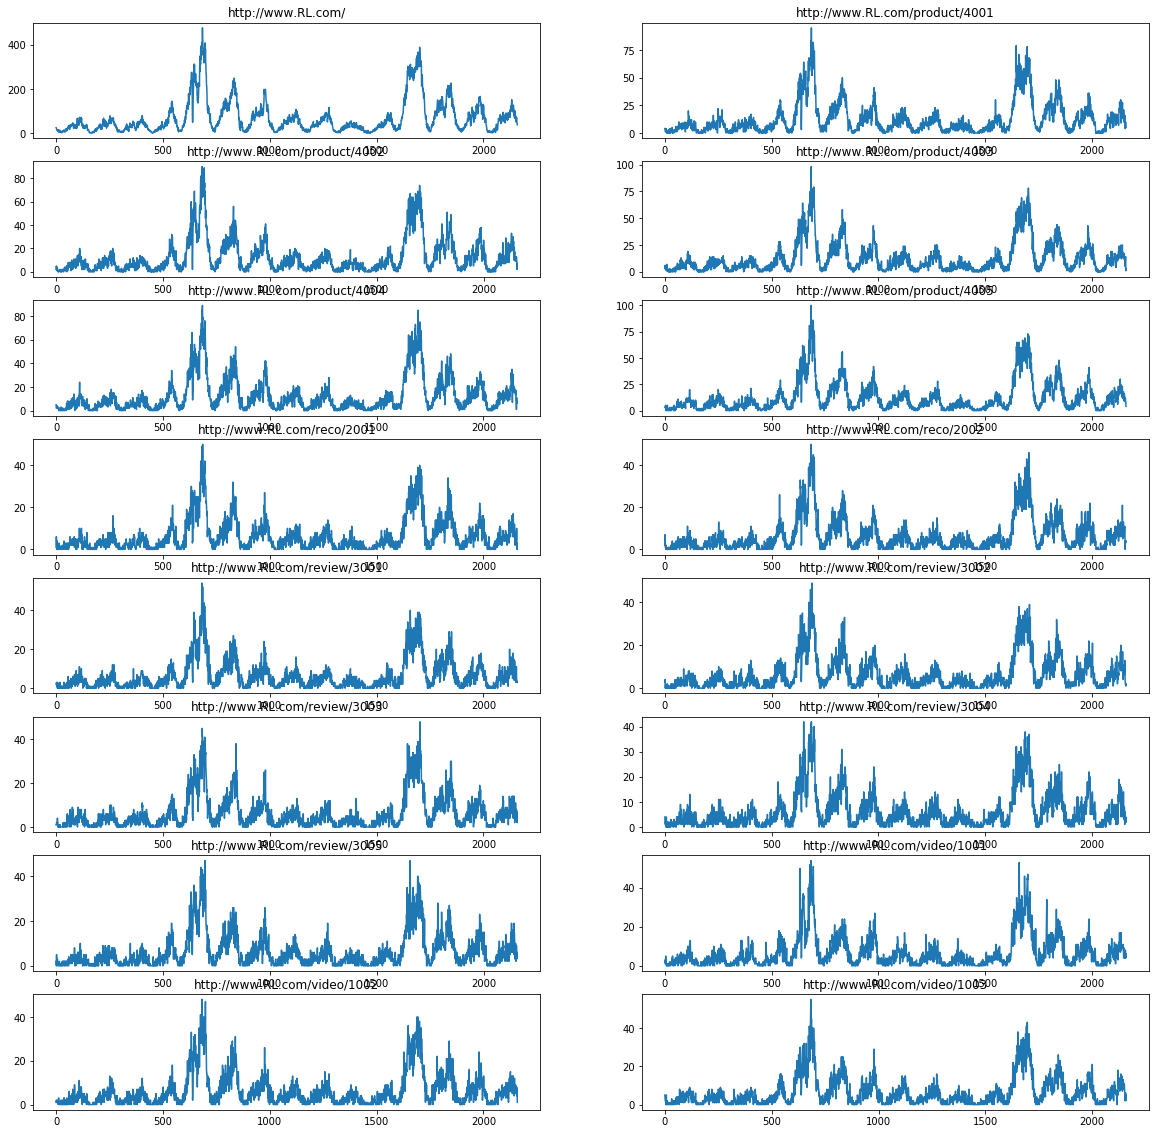

In [24]:
# css = css.groupby(['url','timestamp','user_session_id']).count().reset_index()
# # css.set_index(['url','timestamp']).resample('10T').nunique()
# urls = css.url.unique()
plt.figure(figsize=(20,20))
data = []
for index, url in zip(range(len(urls)), urls):
    r = css[css['url'] == url].set_index('timestamp').resample('10T')
    l = {'start' : str(r.nunique().index[0]),
         'target': list(r.sum()['clickstream_id'].values.astype('float')),
         'dynamic_feat': [list(r.nunique()['user_session_id'].values.astype('float'))]
        }
    data.append(l)
    
    # optional 
    plt.subplot(8,2, index+1)
    plt.plot(l['target'])
    plt.title(url)
    

In [27]:
import json

def write_dicts_to_file(path, data):
    with open(path, 'wb') as fp:
        for d in data:
            fp.write(json.dumps(d).encode("utf-8"))
            fp.write("\n".encode('utf-8'))
            
write_dicts_to_file("train.json", data)

## 1. Kinesis Analytics를 이용한 실시간 이상감지

The algorithm starts developing the machine learning model using current records in the stream when you start the application. The algorithm does not use older records in the stream for machine learning, nor does it use statistics from previous executions of the application.

In [28]:
import json
import random
import boto3
import sys
import os
import time

In [29]:
kinesis_client = boto3.client('kinesis')
kinesis_analytics = boto3.client('kinesisanalytics')

### 1.1 Input/Output Create_stream 생성

In [38]:
data_stream = ['clickstream_input', 'clickstream_output']

try:
    for stream in data_stream:
        kinesis_client.create_stream(
            StreamName=stream,
            ShardCount=1
        )
except Exception as e:
    if e.response['Error']['Code'] == 'ResourceInUseException':
        print(e.response['message'])
    else:
        print(e.response['Error']['Code'])
    

Stream clickstream_input under account 322537213286 already exists.


In [40]:
# Wait until all streams are created
result = {}
waiter = kinesis_client.get_waiter('stream_exists')
for stream in data_stream:
    waiter.wait(StreamName=stream)
    response = kinesis_client.describe_stream(StreamName=stream)
    result[stream] = response["StreamDescription"]["StreamARN"]

### 1.2 IAM 생성

In [41]:
region = boto3.Session().region_name

iam = boto3.client('iam')
sts = boto3.client('sts')

In [43]:
kinesis_role_name = 'kinesis-analytics-{}'.format(region)
kinesis_analytics_policy_name=kinesis_role_name + '_policy'
kinesis_role_name

'kinesis-analytics-us-east-2'

In [44]:
kinesis_assume_role={
  "Version": "2012-10-17",
  "Statement": [
    {
      "Effect": "Allow",
      "Principal": {
        "Service": "kinesisanalytics.amazonaws.com"
      },
      "Action": "sts:AssumeRole"
    }
  ]
}

In [45]:
kinesis_analytics_policy = {
  "Version": "2012-10-17",
  "Statement": [
    {
      "Sid": "ReadInputKinesis",
      "Effect": "Allow",
      "Action": [
        "kinesis:DescribeStream",
        "kinesis:GetShardIterator",
        "kinesis:GetRecords"
      ],
      "Resource": [
        result['clickstream_input']
      ]
    },
    {
      "Sid": "WriteOutputKinesis",
      "Effect": "Allow",
      "Action": [
        "kinesis:DescribeStream",
        "kinesis:PutRecord",
        "kinesis:PutRecords"
      ],
      "Resource": [
        result['clickstream_output']
      ]
    }
  ]
}

In [47]:
role_res = iam.create_role(
    Path='/service-role/',
    RoleName=kinesis_role_name,
    AssumeRolePolicyDocument=json.dumps(kinesis_assume_role),
)

In [48]:
policy_res = iam.create_policy(
    PolicyName=kinesis_analytics_policy_name,
    Path='/',
    PolicyDocument=json.dumps(kinesis_analytics_policy)
)

In [49]:
from botocore.exceptions import ClientError

try:
    attach_res = iam.attach_role_policy(
        PolicyArn=policy_res['Policy']['Arn'],
        RoleName=kinesis_role_name
    )
    print("Policy has been succesfully attached to role: %s" % kinesis_role_name)
except ClientError as e:
    if e.attach_res['Error']['Code'] == 'EntityAlreadyExists':
        print("Policy is already attached. This is OK.")
    elif e.attach_res['Error']['Code'] == 'LimitExceeded':
        print("We reached the max. of 10 attached policies per role. This is OK.")
    else:
        print("Unexpected error: %s" % e)

Policy has been succesfully attached to role: kinesis-analytics-us-east-2


### 1.3 Create Application

In [50]:
sql_query = open('random_cut_forest.sql', "r").read()

In [51]:
kinesis_ApplicationName='clickstream-analytics-rcf'

In [54]:
try:
    response = kinesis_analytics.create_application(
        ApplicationName=kinesis_ApplicationName,
        ApplicationCode=sql_query,
        Inputs=[
            {
                'NamePrefix': 'SOURCE_SQL_STREAM',
                'KinesisStreamsInput': {
                    'ResourceARN': result[data_stream[0]],
                    'RoleARN': role_res['Role']['Arn']
                },
                'InputSchema': {
                    'RecordFormat': {
                        'RecordFormatType': 'JSON',
                        'MappingParameters': {
                            'JSONMappingParameters': {
                                'RecordRowPath': '$'
                            },
                        }
                    },
                    'RecordEncoding': 'UTF-8',
                    'RecordColumns': [
                                {
                                    "SqlType": "TIMESTAMP",
                                    "Name": "TIMESTAMPS",
                                    "Mapping": "$.timestamp"
                                },
                                {
                                    "SqlType": "VARCHAR(50)",
                                    "Name": "IP_ADDRESS",
                                    "Mapping": "$.ip_address"
                                },
                                {
                                    "SqlType": "VARCHAR(50)",
                                    "Name": "URL",
                                    "Mapping": "$.url"
                                },
                                {
                                    "SqlType": "INTEGER",
                                    "Name": "IS_PURCHASED",
                                    "Mapping": "$.is_purchased"
                                },
                                {
                                    "SqlType": "DOUBLE",
                                    "Name": "IS_PAGE_ERRORED",
                                    "Mapping": "$.is_page_errored"
                                },
                                {
                                    "SqlType": "VARCHAR(100)",
                                    "Name": "USER_SESSION_ID",
                                    "Mapping": "$.user_session_id"
                                },
                                {
                                    "SqlType": "VARCHAR(100)",
                                    "Name": "CITY",
                                    "Mapping": "$.city"
                                },
                                {
                                    "SqlType": "VARCHAR(10)",
                                    "Name": "STATE",
                                    "Mapping": "$.state"
                                },
                                {
                                    "SqlType": "VARCHAR(20)",
                                    "Name": "COUNTRY",
                                    "Mapping": "$.country"
                                },
                                {
                                    "SqlType": "VARCHAR(20)",
                                    "Name": "BIRTH_DT",
                                    "Mapping": "$.BIRTH_DT"
                                },
                                {
                                    "SqlType": "VARCHAR(5)",
                                    "Name": "GENDER_CD",
                                    "Mapping": "$.GENDER_CD"
                                }
                    ],
                    "RecordFormat": {
                        "MappingParameters": {
                            'JSONMappingParameters': {
                                'RecordRowPath': '$'
                            },
                        },
                        "RecordFormatType": "JSON"
                      }
                }
            },
        ],
        Outputs=[
            {
                'Name': 'DESTINATION_SQL_STREAM',
                'DestinationSchema': {
                    'RecordFormatType': 'JSON'
                },
                "KinesisStreamsOutput": {
                    "ResourceARN": result[data_stream[1]],
                    "RoleARN": role_res['Role']['Arn']
                }
            },
        ],
    )
except Exception as e:
    if e.response['Error']['Code'] == 'ResourceInUseException':
        print(e.response['message'])
    else:
        print(e.response['Error']['Code'])

Application 'clickstream-analytics-rcf' already exists.


### 1.5 Start Application

In [56]:
response = kinesis_analytics.describe_application(
    ApplicationName=kinesis_ApplicationName
)

application = response["ApplicationDetail"]
inputId = application['InputDescriptions'][0]['InputId']

try:
    kinesis_analytics.start_application(ApplicationName=kinesis_ApplicationName,
                                     InputConfigurations=[{
                                       "Id": inputId,
                                       "InputStartingPositionConfiguration": {
                                         "InputStartingPosition": "NOW"
                                       }
                                     }])
except Exception as e:
    if e.response['Error']['Code'] == 'ResourceInUseException':
        print(e.response['message'])
    else:
        print(e.response['Error']['Code'])

Application cannot be started in 'RUNNING' state


In [57]:
# Wait until application starts running
response = kinesis_analytics.describe_application(
    ApplicationName=kinesis_ApplicationName
)
status = response["ApplicationDetail"]["ApplicationStatus"]

sys.stdout.write('Starting ')
while status != "RUNNING":
    sys.stdout.write('.')
    sys.stdout.flush()
    time.sleep(1)
    response = kinesis_analytics.describe_application(
      ApplicationName=kinesis_ApplicationName
    )
    status = response["ApplicationDetail"]["ApplicationStatus"]
sys.stdout.write('RUNNING')
sys.stdout.write(os.linesep)

Starting RUNNING


###  1.7 Sending Input Stream

In [209]:
r_users = users.rename({'SWID':'user_session_id'}, axis='columns')
r_cs = cs.rename({'IP address':'ip_address','is_purchased?':'is_purchased'
                ,'is_page_errored?':'is_page_errored', }, axis='columns')
r_cs = r_cs.reset_index()

In [210]:
## Data merge
r_css = pd.merge(r_cs, r_users, how='left')

## Delete NaN and dup-data for timestamp
r_css = r_css.dropna(axis=0)
# r_css = r_css.drop_duplicates(['timestamp'])
r_css_sorted = r_css.sort_values(by=['timestamp'])
r_css_sorted = r_css_sorted.set_index('timestamp')

In [214]:
opsd_monthly = r_css_sorted.resample('S').sum()
opsd_monthly.head(3)

,clickstream_id,is_purchased,is_page_errored
timestamp,,,
2012-03-01 00:01:30,1330588890,0,0.000000
2012-03-01 00:01:31,1330588891,0,0.919192
2012-03-01 00:01:32,0,0,0.000000


In [66]:
def make_kinesis_data(idx, col_names):
    kinesis_data = {}
    kinesis_data['timestamp']=str(idx)
    for col_name in col_names:
        if col_name not in ['clickstream_id']:
            if col_name in ['is_purchased']:
                kinesis_data[col_name]=int(r_css_sorted.loc[idx][col_name])
            else:
                kinesis_data[col_name]=r_css_sorted.loc[idx][col_name]
    return kinesis_data

In [143]:
total_cnt = 5000

In [144]:
response = kinesis_client.describe_stream(StreamName=data_stream[1])
shardId = response["StreamDescription"]["Shards"][0]["ShardId"]
response = kinesis_client.get_shard_iterator(StreamName=data_stream[1],
                                    ShardId=shardId,
                                    ShardIteratorType="LATEST")
shardIterator = response["ShardIterator"]

In [145]:
kinesis_data = {}
rnd=random.random()
col_names = r_css_sorted.keys().to_list()
for i, idx in enumerate(r_css_sorted.index):
    kinesis_data = json.dumps(make_kinesis_data(idx, col_names))
    kinesis_client.put_record(
        StreamName=data_stream[0],
        Data=kinesis_data,
        PartitionKey=str(rnd)
    )
    if i == total_cnt:
        break

In [146]:
rows = []
sys.stdout.write("\rProcessed 0/{} ".format(total_cnt))
sys.stdout.flush()

try:
    while len(rows) < total_cnt:
        response = kinesis_client.get_records(ShardIterator=shardIterator)
        records = response["Records"]
        if len(records) > 0:
            parsed_records = []
            for rec in records:
                parsed_record = json.loads(rec["Data"])
                parsed_records.append(parsed_record)
            rows.extend(parsed_records)
            shardIterator = response["NextShardIterator"]
            sys.stdout.write("\rProcessed {}/{} ".format(len(rows), total_cnt))
            sys.stdout.flush()
        else:
            # Back off until the application starts streaming the anomalies
            sys.stdout.write(".")
            sys.stdout.flush()
            time.sleep(1)
except:
    sys.stdout.write("[ExpiredIteratorException] Iterator expired.")
    pass
sys.stdout.write(os.linesep)


Processed 5001/5000 .....


In [192]:
kinesis_analytics.stop_application(ApplicationName=kinesis_ApplicationName)

# Wait until application stops running
response = kinesis_analytics.describe_application(
    ApplicationName=kinesis_ApplicationName
)
status = response["ApplicationDetail"]["ApplicationStatus"]
sys.stdout.write('Stopping ')

while status != "READY":
    sys.stdout.write('.')
    sys.stdout.flush()
    time.sleep(1)
    response = kinesis_analytics.describe_application(
        ApplicationName=kinesis_ApplicationName
    )
    status = response["ApplicationDetail"]["ApplicationStatus"]

sys.stdout.write(os.linesep)

Stopping ....


In [169]:
rcf_result = pd.DataFrame(rows)

In [170]:
import seaborn as sns

In [171]:
col_data = rcf_result.loc[:,['IS_PURCHASED','IS_PAGE_ERRORED','ANOMALY_SCORE']]

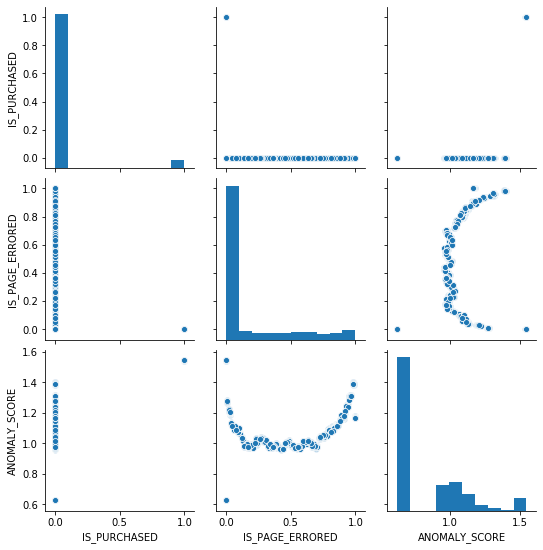

In [172]:
sns.pairplot(col_data)

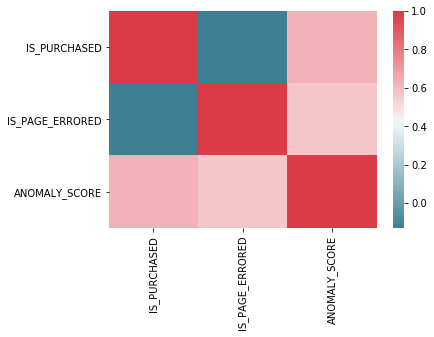

In [173]:
corr = col_data.corr()
sns.heatmap(corr, 
            xticklabels=corr.columns, 
            yticklabels=corr.columns, 
            cmap=sns.diverging_palette(220, 10, as_cmap=True))

In [186]:
import datetime as dt
import matplotlib.pyplot as plt
import matplotlib.ticker as ticker

revised_rcf_result = rcf_result
revised_rcf_result.set_index("TIMESTAMPS", inplace=True)

revised_rcf_result['datatime_timestamps'] =  [dt.datetime.strptime(data[:19], '%Y-%m-%d %H:%M:%S') for data in revised_rcf_result.index]
revised_rcf_result.reset_index()
revised_rcf_result.set_index("datatime_timestamps", inplace=True)

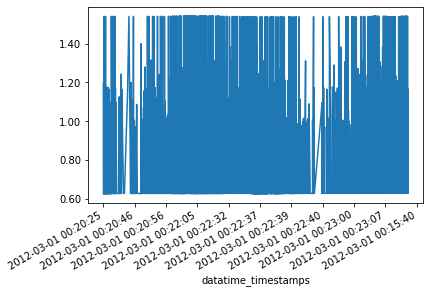

In [191]:
ax = revised_rcf_result['ANOMALY_SCORE'].plot()

ticklabels = revised_rcf_result.index.strftime('%Y-%m-%d %H:%M:%S')
ax.xaxis.set_major_formatter(ticker.FixedFormatter(ticklabels))
ax.yaxis.set_major_formatter(ticker.FormatStrFormatter('%.2f'))
plt.show()

In [ ]:
# anal_res = kinesis_analytics.describe_application(
#     ApplicationName=kinesis_ApplicationName
# )

# kinesis_analytics.delete_application(
#       ApplicationName=kinesis_ApplicationName,
#       CreateTimestamp=anal_res['ApplicationDetail']['CreateTimestamp']
# )

## 2. Cloud Watch AD를 이용한 모니터링

## 3. SageMaker Random Cut Forest 를 이용한 이상치 분석

## 4. 시계열 예측 기법을 이용한 이상치 분석

In [ ]:
import sagemaker

sagemaker_session = sagemaker.Session()
s3_bucket = sagemaker.Session().default_bucket()  # replace with an existing bucket if needed
s3_prefix = 'deepar-clickstream'    # prefix used for all data stored within the bucket

role = sagemaker.get_execution_role()             # IAM role to use by SageMaker

In [ ]:
train_s3 = sagemaker_session.upload_data(path='train.json', key_prefix=s3_prefix)
train_s3

In [ ]:
import s3fs

s3filesystem = s3fs.S3FileSystem()
with s3filesystem.open(train_s3, 'rb') as fp:
    print(fp.readline().decode("utf-8")[:100] + "...")

#### SageMaker DeepAR Tranining

In [ ]:
import datetime 

region = sagemaker_session.boto_region_name

# we use 2 hour frequency for the time series
freq = datetime.timedelta(minutes=10)

# we predict for 24 hours
prediction_length = 24 * 6

# we also use 7 days as context length, this is the number of state updates accomplished before making predictions
context_length = 24 * 6

image_name = sagemaker.amazon.amazon_estimator.get_image_uri(region, "forecasting-deepar", "latest")

In [ ]:
estimator = sagemaker.estimator.Estimator(
    sagemaker_session=sagemaker_session,
    image_name=image_name,
    role=role,
    train_instance_count=1,
    train_instance_type='ml.c4.2xlarge',
    base_job_name='deepar-clickstream'
)

In [ ]:
hyperparameters = {
    "time_freq": '10min',
    "epochs": "400",
    "early_stopping_patience": "40",
    "mini_batch_size": "64",
    "learning_rate": "5E-4",
    "context_length": str(context_length),
    "prediction_length": str(prediction_length)
}
estimator.set_hyperparameters(**hyperparameters)

In [ ]:
%%time
data_channels = {
    "train": train_s3
}

estimator.fit(data_channels, wait=True)

In [ ]:
class DeepARPredictor(sagemaker.predictor.RealTimePredictor):
    
    def __init__(self, *args, **kwargs):
        super().__init__(*args, content_type=sagemaker.content_types.CONTENT_TYPE_JSON, **kwargs)
        
    def predict(self, ts, cat=None, dynamic_feat=None, 
                num_samples=100, return_samples=False, quantiles=["0.1", "0.5", "0.9"]):
        """Requests the prediction of for the time series listed in `ts`, each with the (optional)
        corresponding category listed in `cat`.
        
        ts -- `pandas.Series` object, the time series to predict
        cat -- integer, the group associated to the time series (default: None)
        num_samples -- integer, number of samples to compute at prediction time (default: 100)
        return_samples -- boolean indicating whether to include samples in the response (default: False)
        quantiles -- list of strings specifying the quantiles to compute (default: ["0.1", "0.5", "0.9"])
        
        Return value: list of `pandas.DataFrame` objects, each containing the predictions
        """
        prediction_time = ts.index[-1] + datetime.timedelta(minutes=10)
#         prediction_time = 144
        quantiles = [str(q) for q in quantiles]
        req = self.__encode_request(ts, cat, dynamic_feat, num_samples, return_samples, quantiles)
        res = super(DeepARPredictor, self).predict(req)
        return self.__decode_response(res, ts.index.freq, prediction_time, return_samples)
    
    def __encode_request(self, ts, cat, dynamic_feat, num_samples, return_samples, quantiles):
        instance = series_to_dict(ts, cat if cat is not None else None, dynamic_feat if dynamic_feat else None)

        configuration = {
            "num_samples": num_samples,
            "output_types": ["quantiles", "samples"] if return_samples else ["quantiles"],
            "quantiles": quantiles
        }
        
        http_request_data = {
            "instances": [instance],
            "configuration": configuration
        }
        
        return json.dumps(http_request_data).encode('utf-8')
    
    def __decode_response(self, response, freq, prediction_time, return_samples):
        # we only sent one time series so we only receive one in return
        # however, if possible one will pass multiple time series as predictions will then be faster
        predictions = json.loads(response.decode('utf-8'))['predictions'][0]
        prediction_length = len(next(iter(predictions['quantiles'].values())))
#         prediction_index = pd.DatetimeIndex(start=prediction_time, freq=freq, periods=prediction_length)       
#         print(prediction_time)
#         print(type(prediction_time))
#         print(prediction_length)
#         print(type(prediction_length))
#         print(freq)
#         print(type(freq))
        
        prediction_index = pd.date_range(prediction_time, prediction_time + freq * (prediction_length-1), freq=freq)
#         print(prediction_index)
        
        if return_samples:
            dict_of_samples = {'sample_' + str(i): s for i, s in enumerate(predictions['samples'])}
        else:
            dict_of_samples = {}
        return pd.DataFrame(data={**predictions['quantiles'], **dict_of_samples}, index=prediction_index)

    def set_frequency(self, freq):
        self.freq = freq
        
def encode_target(ts):
    return [x if np.isfinite(x) else "NaN" for x in ts]        

def series_to_dict(ts, cat=None, dynamic_feat=None):
    """Given a pandas.Series object, returns a dictionary encoding the time series.

    ts -- a pands.Series object with the target time series
    cat -- an integer indicating the time series category

    Return value: a dictionary
    """
    obj = {"start": str(ts.index[0]), "target": encode_target(ts)}
    if cat is not None:
        obj["cat"] = cat
    if dynamic_feat is not None:
        obj["dynamic_feat"] = dynamic_feat        
    return obj

In [ ]:
predictor.delete_endpoint()
predictor = estimator.deploy(
    initial_instance_count=1,
    instance_type='ml.m4.xlarge',
    predictor_cls=DeepARPredictor, 
    wait=False)

In [ ]:
infs = pd.Series(data[0]['target'][:-144])
infs.index=pd.date_range(data[0]['start'], datetime.datetime.strptime(data[0]['start'],  '%Y-%m-%d %H:%M:%S') + datetime.timedelta(minutes=10*2015), freq='10T')
infs

In [ ]:
prediction = predictor.predict(ts= infs, 
                               dynamic_feat=data[0]['dynamic_feat'],
                               quantiles=[0.10, 0.5, 0.90])

In [ ]:
infsf = pd.Series(data[0]['target'])
infsf.index=pd.date_range(data[0]['start'], datetime.datetime.strptime(data[0]['start'],  '%Y-%m-%d %H:%M:%S') + datetime.timedelta(minutes=10*2159), freq='10T')
infsf

In [ ]:
plt.figure(figsize=(20,8))
plt.plot(infsf['2012-03-13 23:20:00':])
plt.plot(prediction)
plt.show()